In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

Now we will visualize the data so to get some insight
we are loading two dataset
-> In one named 'unique customers' we are getting the unique number of custaomers enabling a skill
-> In second name 'enable_customers' we are getting the the numbers of skill activation

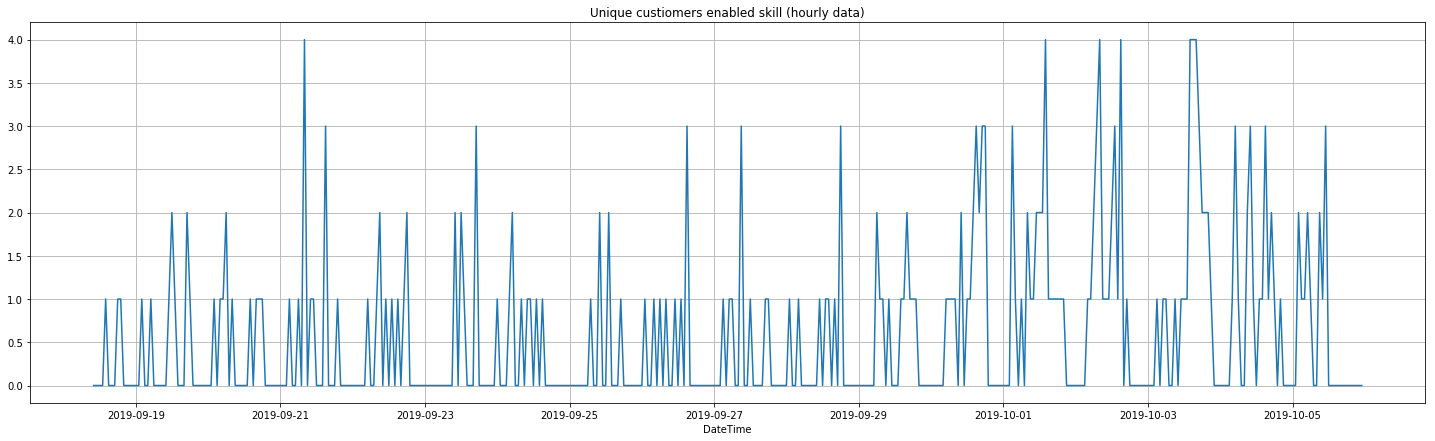

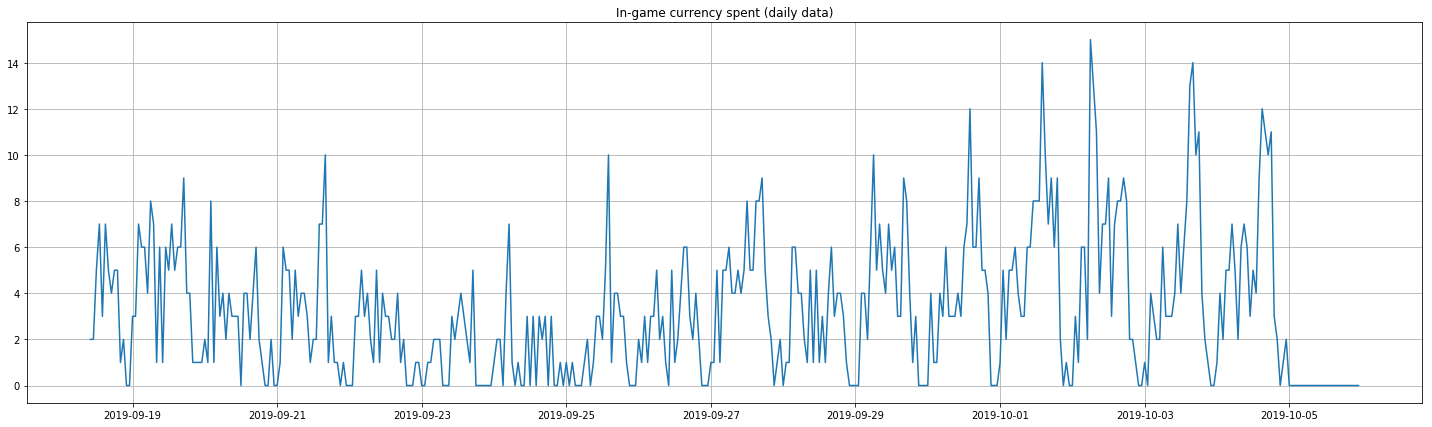

In [2]:
unique_customers = pd.read_csv('D:\Alexa-unique-cust.csv', index_col=['DateTime'], parse_dates=['DateTime'])
enable_customers = pd.read_csv('D:\Total-user-enable.csv', index_col=['DateTime'], parse_dates=['DateTime'])
ucust=unique_customers["2019-09-18 10:00:00":]
encust=enable_customers["2019-09-18 10:00:00":]
plt.figure(figsize=(25, 7))
plt.plot(ucust.Customers)
plt.title('Unique custiomers enabled skill (hourly data)')
plt.xlabel('DateTime')
plt.grid(True)
plt.show()
#encust.info()
plt.figure(figsize=(25,7))
plt.plot(encust.Users)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()


Now we will be getting the info and some dataset exapmle to undertsand the structure of our data

In [3]:
ucust.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 422 entries, 2019-09-18 10:00:00 to 2019-10-05 23:00:00
Data columns (total 1 columns):
Customers    422 non-null int64
dtypes: int64(1)
memory usage: 6.6 KB


In [4]:
ucust.head()

,Customers
DateTime,
2019-09-18 10:00:00,0
2019-09-18 11:00:00,0
2019-09-18 12:00:00,0
2019-09-18 13:00:00,0
2019-09-18 14:00:00,1


In [5]:
encust.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 422 entries, 2019-09-18 10:00:00 to 2019-10-05 23:00:00
Data columns (total 1 columns):
Users    422 non-null int64
dtypes: int64(1)
memory usage: 6.6 KB


In [6]:
encust.head()

,Users
DateTime,
2019-09-18 10:00:00,2
2019-09-18 11:00:00,2
2019-09-18 12:00:00,5
2019-09-18 13:00:00,7
2019-09-18 14:00:00,3


In next block we are going to import some of the librariees required for error calculation so we can get to check our models by using this error functions

In [7]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Here we will apply naive hypothesis 
So here basically we are using technique called moving average
In this our prediction is based on the last n hour

In [8]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ucust, 24) # prediction for the last observed day (past 24 hours)

0.5416666666666666

Now we will define a funtion for plotting the movign average depending on the window 
We will also be calculating confidence interval with mae + scale as the coefficient for multiplying with it the the std deviation this calculation is required for calculating confidence interval
For getting the knowledge of how well are model is able to predict the sesonality we willl we using  anamoly detetction
for that purpose and will we finally plotting these all things on a same plot

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

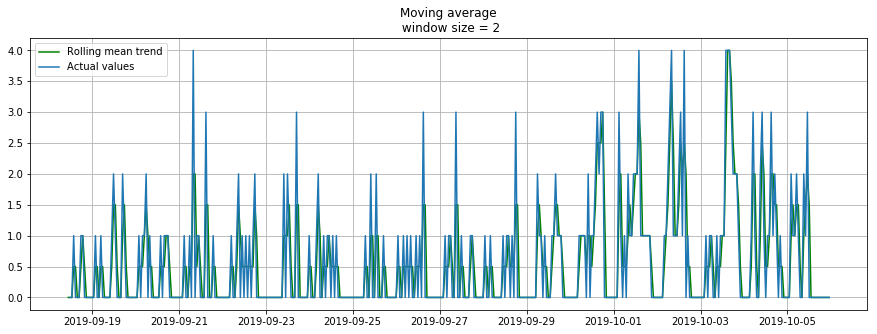

In [10]:
plotMovingAverage(ucust, 2)

In above case we saw that from above graph we are not able to smooth the curve well so now we will increase our window to see how the smoothness get affected

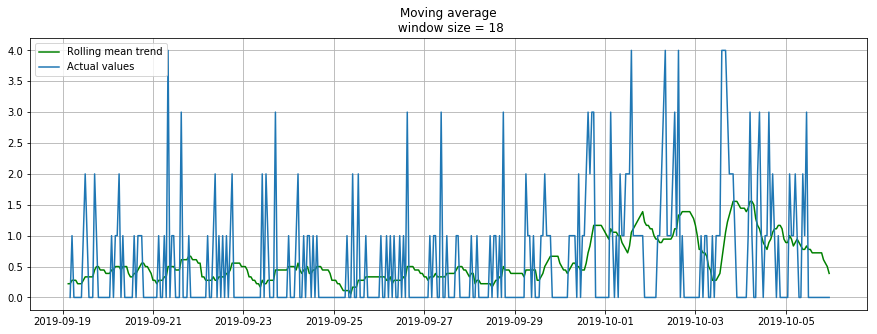

In [11]:
plotMovingAverage(ucust, 18)

In above graph the moving avergae graph got somewhat smoothened but there is still a chance to smooth it 

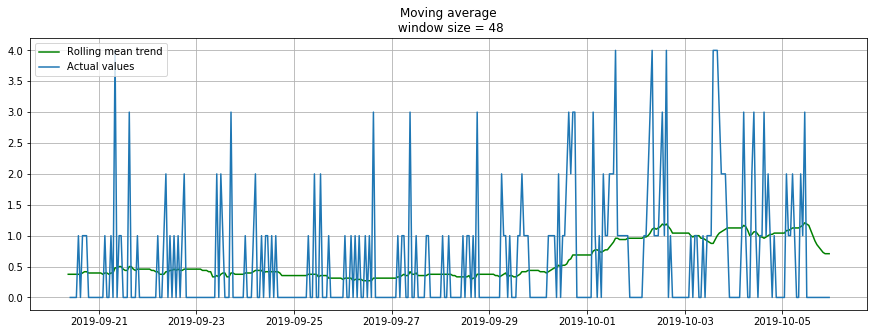

In [12]:
plotMovingAverage(ucust, 48)

So from setting window to 48 hourse i.e 2 days we are getting a good smoothing

Now we will be going to do the same procedure with eanbling datset

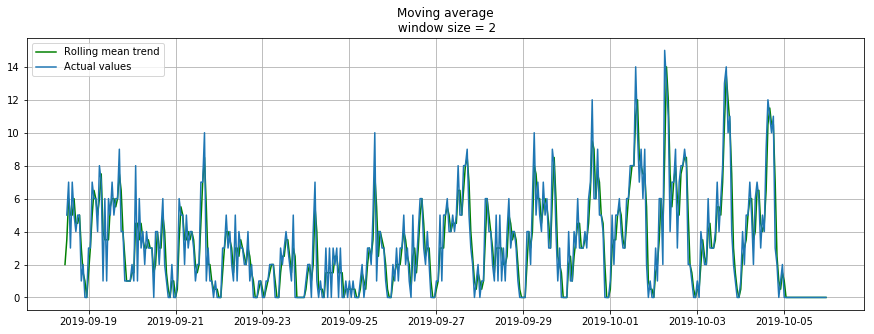

In [13]:
plotMovingAverage(encust, 2)

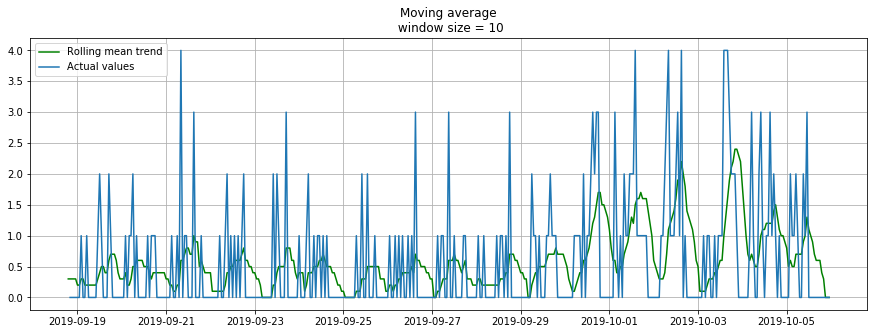

In [14]:
plotMovingAverage(ucust, 10)
                 

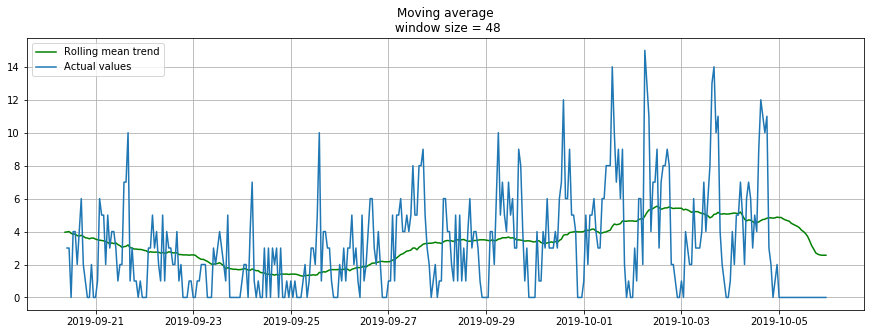

In [15]:
plotMovingAverage(encust,48)

So in this graph again 48b hours window worked well and we got a good amount of smoothing

Now we are going to plot the confidence intervals for the graph so we can get a range in which a value can occur and if it is beyond that we will consider it as anamoly

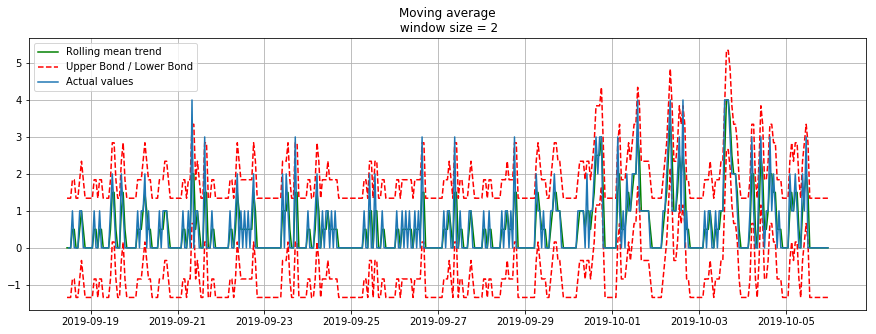

In [16]:
plotMovingAverage(ucust, 2, plot_intervals=True)

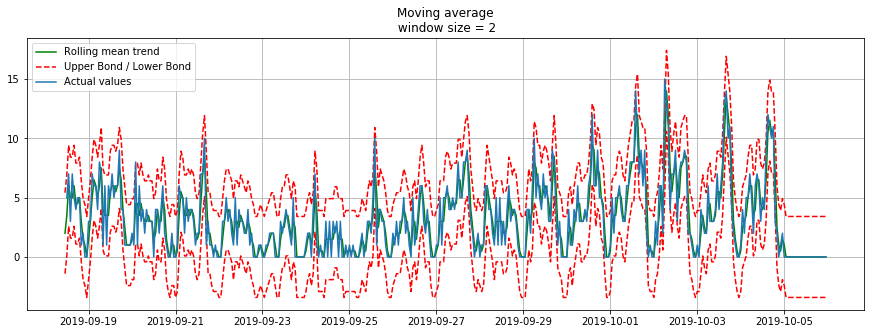

In [17]:
plotMovingAverage(encust, 2, plot_intervals=True)

So now we will set the plot_anamolies so we can see the anamolies plotted in th graph

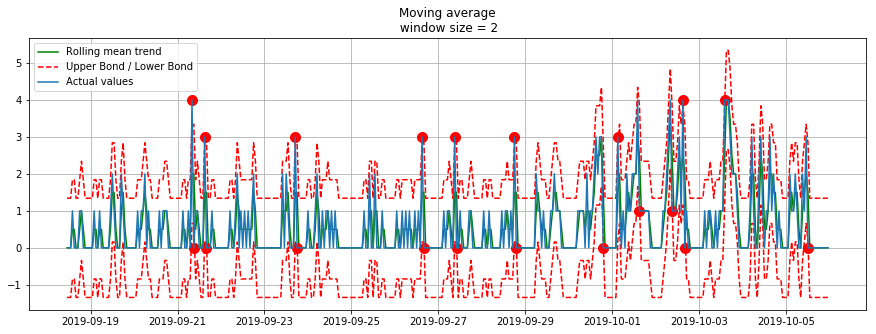

In [18]:
plotMovingAverage(ucust, 2, plot_intervals=True, plot_anomalies=True)


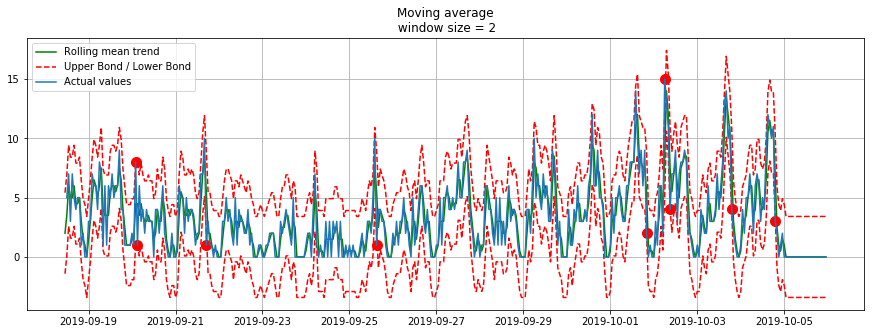

In [19]:
plotMovingAverage(encust, 2, plot_intervals=True, plot_anomalies=True)


In previous cases we set the weight for previous n observation as same but now we will we giving more weight ot the recent value because it should be having more effect on our prediction so we are implementing that in the below defination

In [20]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(encust, [0.6, 0.3, 0.1])

0.0

Now we will be use exponential smoothing in which the coefficients get decayed exponentially 

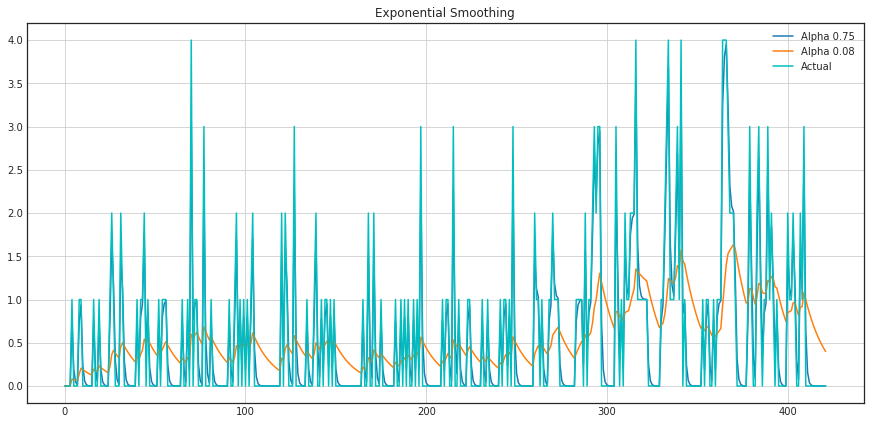

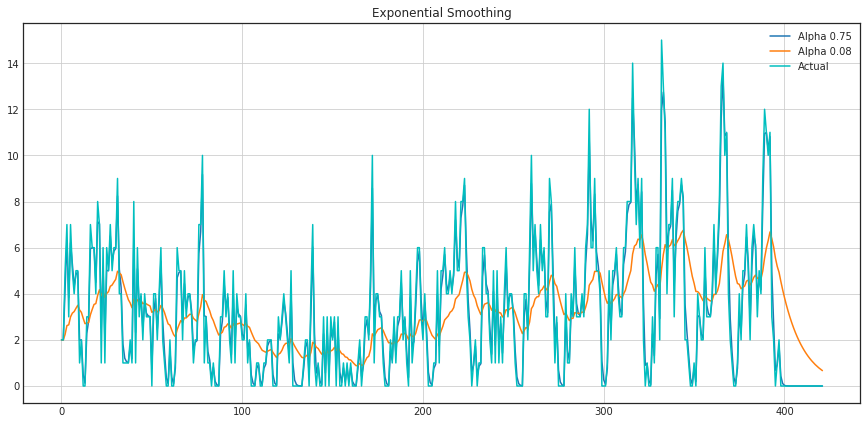

In [21]:

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ucust.Customers, [0.75, 0.08])
plotExponentialSmoothing(encust.Users, [0.75, 0.08])

In the above method we were not able to get the trend and seasonality for the predicted data
So it will not solve our purpose

To solve the above problem we will be using the double exponential smoothing (Holts Exponential method)


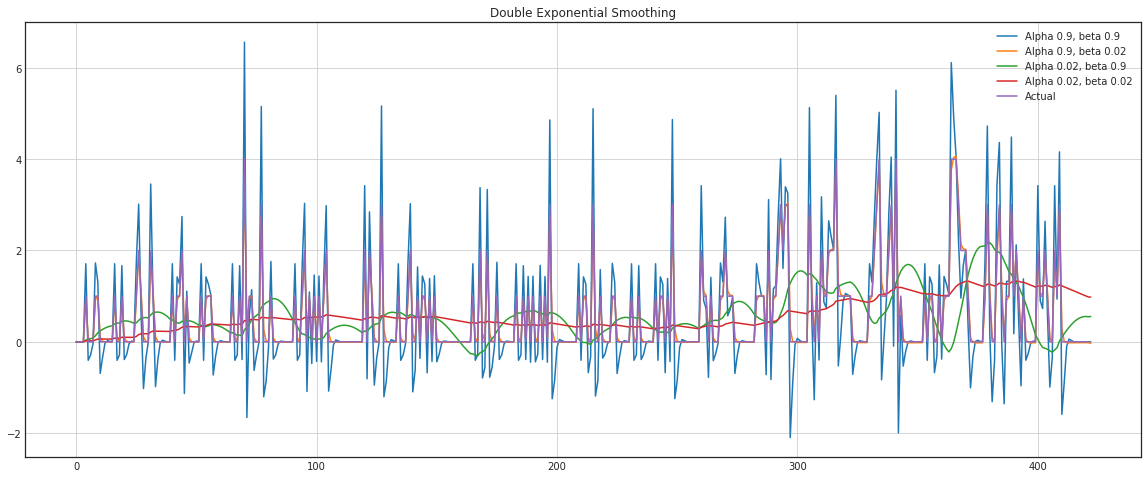

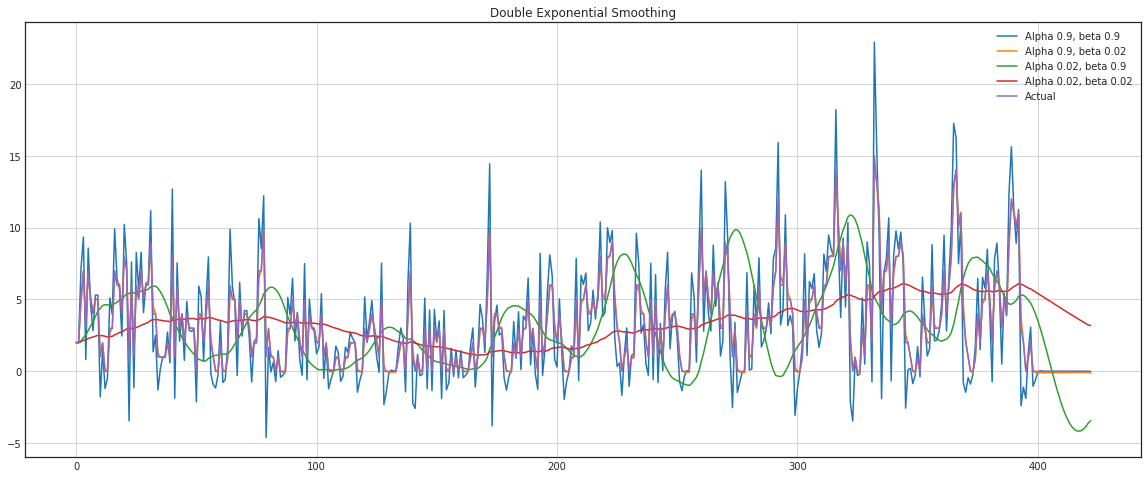

In [22]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(ucust.Customers, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plotDoubleExponentialSmoothing(encust.Users, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In above method we were able to capture the trend but we failed to capture the seasonality

So to solve the problem of seasonality we faced in above method
we will be able to sove that by applying triple exponential smoothing (Holt-Winters method)
fun fact : winters was a student of holt

In [23]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

Plotting the white nosie graph

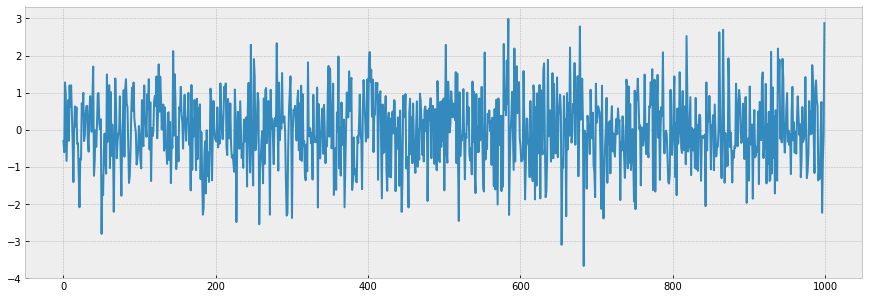

In [24]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

The above plot is stationary which oscillates around 0 with deviation of 1

Now we will plot the graph such that the current value will be dependent on the previous value and 
we will choose the limit of dependency by use of coefficient rho

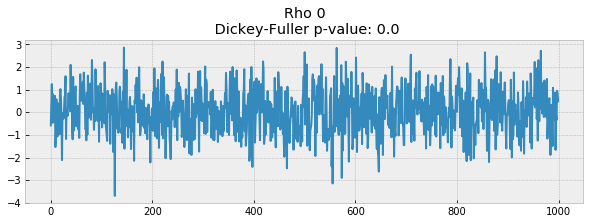

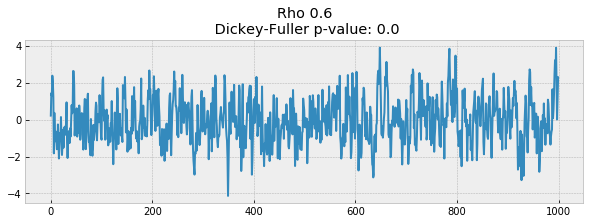

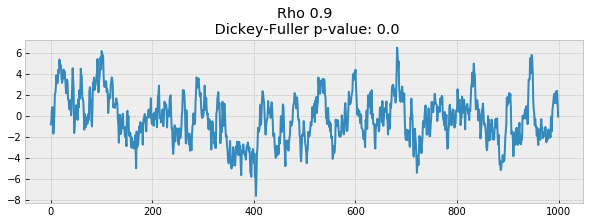

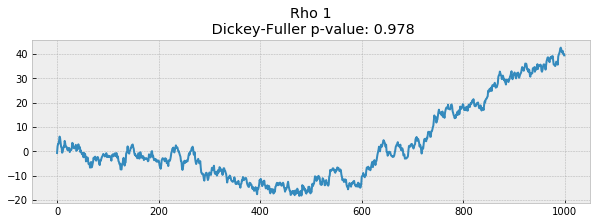

In [25]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

The plot with value of rho =0,0.6,0.9 are statinoary but the graph with rho=1 is not stationary
its an random walk.For checking wether the graph is stationary or not we will be using augmented dicky fuller hyposthsis test and based on the p - value we are commneting on the stationarity of the garph

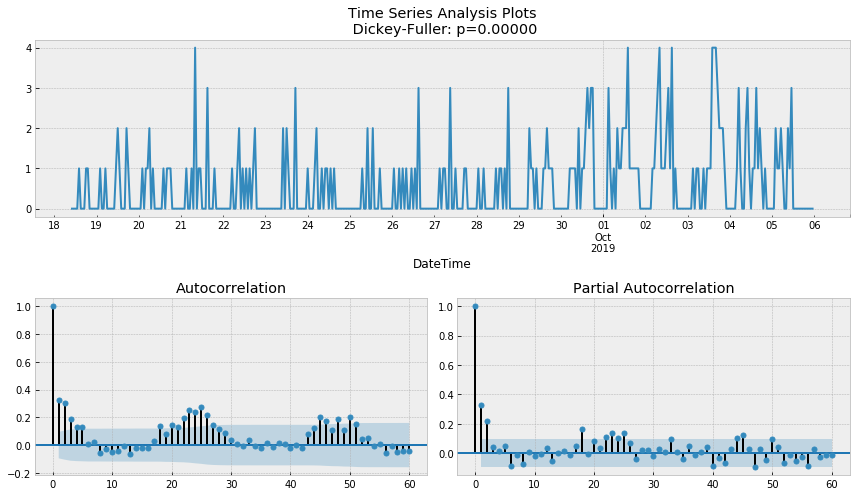

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)                         #creating a series y
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)             #using subplots to plot ultiple plots
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)  
        acf_ax = plt.subplot2grid(layout, (1, 0))      #layout for acf_ax
        pacf_ax = plt.subplot2grid(layout, (1, 1))     #layout for pacf_ax
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]   #getting the p-value of the series for adf
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax) #plotting the acf of the series for given no of lags
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax) #plotting the pacf of the series for given no of lags
        plt.tight_layout()
        
tsplot(ucust.Customers, lags=60)   #Calling the function

ADF test rejected the hyposthesis that the series is non-stationary So now we have to only deal with stationarity To remove seasonality from the plot we will take the seasonal plot


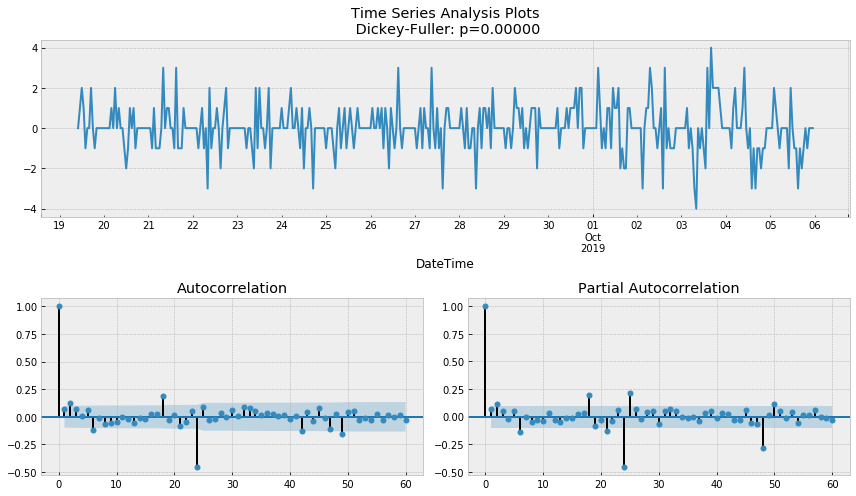

In [27]:
ucust_diff = ucust.Customers- ucust.Customers.shift(24)
tsplot(ucust_diff[24:], lags=60)


In [28]:
#ucust_diff = ucust.Customers- ucust.Customers.shift(28)
#tsplot(ucust_diff[28:], lags=60)

In [29]:
#ucust_diff = ucust.Customers- ucust.Customers.shift(36)
#tsplot(ucust_diff[36:], lags=60)

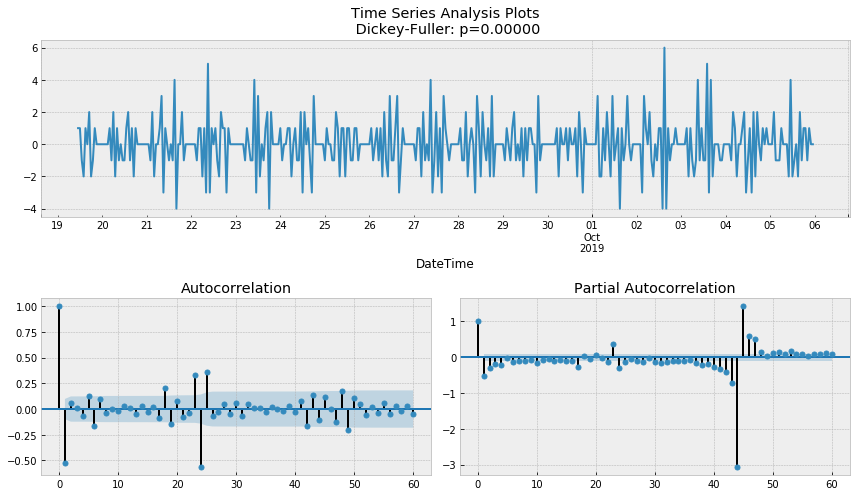

In [30]:
ucust_diff = ucust_diff- ucust_diff.shift(1)
tsplot(ucust_diff[24+1:], lags=60)

Now we will use the SARIMAX class get  the optimum orders we will use iteration for the orders then compare them on the basis of aic and the model with least aic will be cinsidered tobe fitted

In [31]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [43]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX( ucust.Customers, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

result_table = optimizeSARIMA(parameters_list, d, D, s)


As we have sorted the datfarme on base of the table so the model with least aic will be the first row so we will get parameters from first row

In [45]:
# set the parameters that give the lowest AIC

p, q, P, Q = result_table.parameters[0]     #unpackignthe parameters and assiging them to corresponding variavbles

best_model=sm.tsa.statespace.SARIMAX(ucust.Customers, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)  #fiiting model with that derived parameters
print(best_model.summary())       #we will be printing the model summary to get the stats related to our model

                                 Statespace Model Results                                 
Dep. Variable:                          Customers   No. Observations:                  422
Model:             SARIMAX(3, 1, 4)x(0, 1, 1, 24)   Log Likelihood                -502.414
Date:                            Thu, 31 Oct 2019   AIC                           1022.827
Time:                                    22:44:58   BIC                           1058.683
Sample:                                09-18-2019   HQIC                          1037.031
                                     - 10-05-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1794      0.170     -6.943      0.000      -1.512      -0.846
ar.L2          0.2454      0.313   

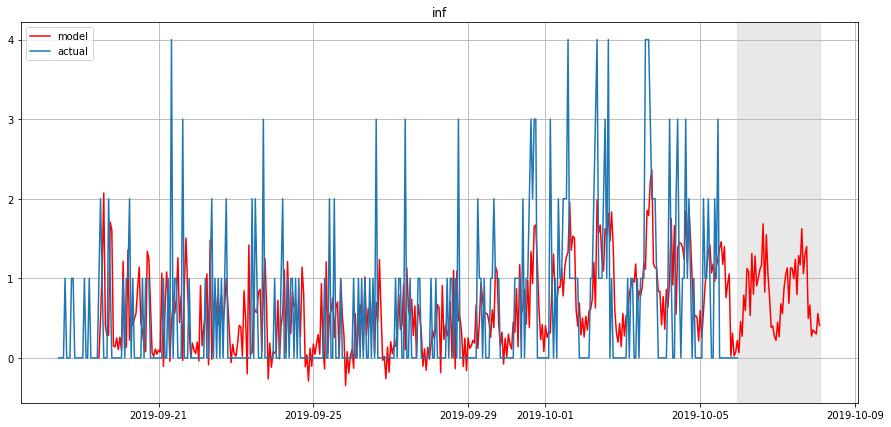

In [53]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title(error)
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ucust, best_model, 50)